### Import libraries

In [79]:

import numpy as np
import pandas as pd
from scipy.stats import beta, multinomial
import scipy.special as sp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML




## Define strategy classes for interaction patterns

In [81]:

class InteractionStrategy:
    """Base class for defining how agents update their beliefs based on signals from other agents"""
    def __init__(self, name="Default"):
        self.name = name
    
    def calculate_update(self, abm, agent_i, agent_a, signal_a, step):
        """Calculate how agent_i should update their beliefs based on signal from agent_a"""
        # Default implementation (original model behavior)
        kl_div = abm.belief_graph[step, agent_i, agent_a]
        update_weight = np.exp(-kl_div) / (abm.n_agents - 1)
        return update_weight
    
    def __str__(self):
        return self.name

class BackfireStrategy(InteractionStrategy):
    """Agents strengthen their existing values when encountering opposing viewpoints"""
    def __init__(self, threshold=2.0, backfire_strength=1.5):
        super().__init__(name=f"Backfire(threshold={threshold}, strength={backfire_strength})")
        self.threshold = threshold
        self.backfire_strength = backfire_strength
    
    def calculate_update(self, abm, agent_i, agent_a, signal_a, step):
        kl_div = abm.belief_graph[step, agent_i, agent_a]
        
        if kl_div > self.threshold:
            # When disagreement is high, strengthen opposition (negative update)
            update_weight = -self.backfire_strength * np.exp(-kl_div) / (abm.n_agents - 1)
        else:
            # Normal positive update for similar agents
            update_weight = np.exp(-kl_div) / (abm.n_agents - 1)
        
        return update_weight

class ConnectionStrategy:
    """Base class for defining which agents remain connected (can influence each other)"""
    def __init__(self, name="FullyConnected"):
        self.name = name
    
    def update_connections(self, abm, step):
        """Update the connection matrix for the next step"""
        # Default: all agents remain connected
        abm.connections[:, :, step+1] = abm.connections[:, :, step]
    
    def __str__(self):
        return self.name

class EchoChamberStrategy(ConnectionStrategy):
    """Agents disconnect from those with sufficiently different beliefs"""
    def __init__(self, disconnect_threshold=3.0, reconnect_threshold=None):
        super().__init__(name=f"EchoChamber(threshold={disconnect_threshold})")
        self.disconnect_threshold = disconnect_threshold
        self.reconnect_threshold = reconnect_threshold or disconnect_threshold * 0.8
    
    def update_connections(self, abm, step):
        # Copy existing connections
        abm.connections[:, :, step+1] = abm.connections[:, :, step]
        
        # Update connections based on belief divergence
        for agent_i in range(abm.n_agents):
            for agent_a in range(abm.n_agents):
                if agent_i == agent_a:
                    continue
                    
                kl_div = abm.belief_graph[step, agent_i, agent_a]
                
                # Disconnect if divergence is too high
                if kl_div > self.disconnect_threshold:
                    abm.connections[agent_i, agent_a, step+1] = 0
                
                # Reconnect if divergence decreases below threshold
                elif kl_div < self.reconnect_threshold and abm.connections[agent_i, agent_a, step] == 0:
                    abm.connections[agent_i, agent_a, step+1] = 1



## Modified MoralABM class

In [82]:
class MoralABM():
    def __init__(self, n_agents=10, n_steps=50, beta_prior=False, priors=[], normalize=False,
                 interaction_strategy=None, connection_strategy=None):
        # Define agents' moral distribution parameters
        if beta_prior:
            self.n_params = 10 + 1  # 10 moral representations (betas) + 1 reliability
        else:
            self.n_params = 5 + 1  # 5 moral representations (dirichlet) + 1 reliability
        
        self.normalize = normalize
        self.n_agents = n_agents
        self.n_steps = n_steps
        
        # Set strategies (with defaults if none provided)
        self.interaction_strategy = interaction_strategy or InteractionStrategy()
        self.connection_strategy = connection_strategy or ConnectionStrategy()
        
        # Moral foundations reference
        self.foundations = ['care', 'fairness', 'ingroup', 'authority', 'purity']
        
        # Initialize agent belief matrices and signals
        self.M_agents = np.zeros((self.n_agents, self.n_agents, self.n_params, self.n_steps))
        self.signals = -np.ones((self.n_agents, self.n_steps))
        self.agent_ids = np.zeros(n_agents)
        
        # Connection matrix (who influences whom)
        self.connections = np.ones((self.n_agents, self.n_agents, self.n_steps))
        
        # Generated graphs
        self.mf_graph = np.zeros((self.n_steps, self.n_agents, self.n_agents))
        self.belief_graph = np.zeros((self.n_steps, self.n_agents, self.n_agents))
        
        if not priors:
            # Set moral distribution priors - different for beta vs dirichlet
            if beta_prior:
                # For beta, we need a and b parameters for each foundation (10 total)
                conservative_priors = [3, 2, 2, 3, 3, 2, 4, 2, 4, 1.5]  # a,b pairs for each foundation
                liberal_priors = [4, 1.5, 4, 1, 2, 3, 1, 4, 1, 4]  # a,b pairs for each foundation
            else:
                # For Dirichlet, one concentration parameter per foundation (5 total)
                conservative_priors = [2, 3, 3, 3, 4]
                liberal_priors = [4, 5, 3, 1, 3]
            
            self.political_priors = [conservative_priors, liberal_priors]
            
            # Set initial conditions
            for agent_i in range(n_agents):
                for agent_a in range(n_agents):
                    self.M_agents[agent_i, agent_a, :(self.n_params-1), 0] = self.M_agents[agent_i, agent_i, :(self.n_params-1), 0]
                
                self.M_agents[agent_i, agent_i, :(self.n_params-1), 0] = self.political_priors[np.random.choice([0, 1], p=[1/2, 1/2])]
        else:
            # If moral foundation priors present
            for agent_i in range(n_agents):
                # First half conservative, second half liberal
                prior = priors[int(agent_i >= n_agents//2)]
                self.agent_ids[agent_i] = int(np.random.choice(prior.index))
                
                for agent_a in range(n_agents):
                    self.M_agents[agent_i, agent_a, :(self.n_params-1), 0] = self.M_agents[agent_i, agent_i, :(self.n_params-1), 0]
                
                self.M_agents[agent_i, agent_i, :(self.n_params-1), 0] = prior[self.agent_ids[agent_i]]
        
        # Set beta (decision) parameters
        self.M_agents[:, :, self.n_params-1, :] = np.ones((self.n_agents, self.n_agents, self.n_steps))
        
        # Run the simulations
        self._run()
    
    # Sample moral values from base distribution
    def sample_moral_values(self, agent_i, agent_a, step):
        M = self.M_agents[agent_i, agent_a, :(self.n_params-1), step]
        
        # Handle potential NaN or negative values
        M = np.nan_to_num(M, nan=1.0)
        M = np.maximum(M, 0.1)  # Ensure all parameters are positive
        
        # Hack for beta distribution 
        if self.n_params > 6:
            try:
                return [beta.rvs(M[i], M[i+1], size=1)[0] for i in 2*np.arange(5)]
            except Exception as e:
                print(f"Error in beta sampling: {e}, using fallback values")
                # Fallback to reasonable values
                return [0.5, 0.5, 0.5, 0.5, 0.5]
        else:
            try:
                return np.random.dirichlet(M, 1)[0]
            except Exception as e:
                print(f"Error in Dirichlet sampling: {e}, using fallback values")
                # Fallback to uniform distribution
                return np.ones(len(M)) / len(M)
    
    # Use the smoothing parameter to influence reliability of the agent
    def softmax(self, x, b=1):
        x = np.array(x)
        # Check for NaN values and replace with small values
        x = np.nan_to_num(x, nan=0.01)
        # Apply softmax with numerical stability
        x_max = np.max(b*x)
        exp_x = np.exp(b*x - x_max)
        sum_exp_x = exp_x.sum()
        if sum_exp_x == 0:
            # Return uniform distribution if sum is zero
            return np.ones_like(x) / len(x)
        return exp_x / sum_exp_x
    
    # Generate a moral signal
    def generate_signal(self, agent_i, step):
        try:
            morals = self.sample_moral_values(agent_i, agent_i, step)
            # Handle potential NaN values
            morals = np.nan_to_num(morals, nan=0.2)
            
            # Get beta parameter, ensure it's positive
            beta_param = max(0.1, self.M_agents[agent_i, agent_i, self.n_params-1, step])
            
            morals_normed = self.softmax(morals, b=beta_param)
            
            # Sanity check for probability distribution
            if not np.isclose(sum(morals_normed), 1.0) or np.any(np.isnan(morals_normed)):
                # Fallback to uniform distribution if invalid
                morals_normed = np.ones(5) / 5
                
            signal = np.random.choice(np.arange(5), p=morals_normed)
            return signal
        except Exception as e:
            print(f"Error in generate_signal for agent {agent_i}: {e}")
            # Fallback to random signal if there's an error
            return np.random.randint(0, 5)
    
    # Compute likelihood of a signal
    def signal_likelihood(self, signal, agent_i, agent_a, step):
        M_i_a = self.sample_moral_values(agent_i, agent_a, step)
        beta = self.M_agents[agent_i, agent_a, self.n_params-1, step]
        # Return the probability of the given signal from normalized morals
        return self.softmax(M_i_a, beta=beta)[int(signal)]
    
    # KL divergence computation
    def KL_divergence(self, agent_p, agent_q, step, belief=True):
        try:
            # Belief of agent_q about agent_p's values
            rep_p = self.M_agents[(agent_q if belief else agent_p), agent_p, :(self.n_params-1), step] 
            rep_q = self.M_agents[agent_q, agent_q, :(self.n_params-1), step]  # agent_q's actual values
            
            # Handle potential NaN or negative values
            rep_p = np.nan_to_num(rep_p, nan=1.0)
            rep_q = np.nan_to_num(rep_q, nan=1.0)
            
            # Ensure all parameters are positive (required for KL divergence)
            rep_p = np.maximum(rep_p, 0.1)
            rep_q = np.maximum(rep_q, 0.1)
            
            if self.n_params > 6:
                KL_div = sum([self._dirichlet_KL(rep_p[m:m+2], rep_q[m:m+2]) for m in 2*np.arange(5)])
            else:
                KL_div = self._dirichlet_KL(rep_p, rep_q)
            
            # Ensure KL divergence is non-negative
            KL_div = max(0, KL_div)
            
            return KL_div
        except Exception as e:
            print(f"Error in KL_divergence: {e}")
            # Return a default value if there's an error
            return 1.0

    def _dirichlet_KL(self, p, q):
        try:
            # Safety checks
            p = np.array(p, dtype=float)
            q = np.array(q, dtype=float)
            
            # Ensure positive values to avoid log(0) or division by zero issues
            p = np.maximum(p, 0.1)
            q = np.maximum(q, 0.1)
            
            p_sum = sum(p)
            q_sum = sum(q)
            
            # Avoid numerical issues with very large or small values
            if p_sum > 1e6 or q_sum > 1e6:
                # For very large concentration parameters, use approximation
                # based on means of distributions
                p_mean = p / p_sum
                q_mean = q / q_sum
                # Simple KL divergence approximation for large alpha
                return np.sum(p_mean * np.log(p_mean / q_mean))

            term1 = sp.gammaln(p_sum) - sp.gammaln(q_sum)
            term2 = sp.gammaln(q).sum() - sp.gammaln(p).sum()
            term3 = np.sum([(alpha_p-alpha_q) * (sp.psi(alpha_p)-sp.psi(p_sum)) 
                          for alpha_p, alpha_q in zip(p, q)])

            result = term1 + term2 + term3
            
            # Handle numerical instability
            if np.isnan(result) or np.isinf(result):
                # Fallback to a simpler approximation
                p_norm = p / p_sum
                q_norm = q / q_sum
                result = np.sum(p_norm * np.log(p_norm / q_norm + 1e-10))
                
            return max(0, result)  # Ensure non-negative
            
        except Exception as e:
            print(f"Error in _dirichlet_KL: {e}")
            return 0.5  # Return a default moderate value on error
    
    # Modified update_morality method with modular interaction
    def update_morality(self, step):
        if self.normalize:
            for agent_i in range(self.n_agents):
                for agent_a in range(self.n_agents):
                    if self.n_params > 6:
                        for i in 2*np.arange(5):
                            unnormed_vals = self.M_agents[agent_i, agent_a, i:i+2, step]
                            # Check for division by zero
                            total = sum(unnormed_vals)
                            if total > 0:
                                self.M_agents[agent_i, agent_a, i:i+2, step] = unnormed_vals/total
                            else:
                                # Default to equal probabilities if sum is zero
                                self.M_agents[agent_i, agent_a, i:i+2, step] = np.array([0.5, 0.5])
                    else:
                        unnormed_vals = self.M_agents[agent_i, agent_a, :(self.n_params-1), step]
                        # Check for division by zero
                        total = sum(unnormed_vals)
                        if total > 0:
                            self.M_agents[agent_i, agent_a, :(self.n_params-1), step] = unnormed_vals/total
                        else:
                            # Default to equal probabilities if sum is zero
                            self.M_agents[agent_i, agent_a, :(self.n_params-1), step] = np.ones(self.n_params-1)/(self.n_params-1)
            
        self.M_agents[:, :, :, step+1] = self.M_agents[:, :, :, step]  # Copy last state
        
        # Update connections using the connection strategy
        self.connection_strategy.update_connections(self, step)
        
        for agent_i in range(self.n_agents):
            for agent_a in range(self.n_agents):
                # Skip if agents are not connected
                if self.connections[agent_i, agent_a, step] == 0:
                    continue
                    
                signal_a = int(self.signals[agent_a, step])
                if self.n_params > 6:
                    self.M_agents[agent_i, agent_a, :(self.n_params-1), step+1][2*signal_a] += 1  # Beta-Multinomial update
                    # Increase the b parameter of the other moral foundations by 1/4 each
                    b_locs = np.delete((2*np.arange(5))+1, signal_a)
                    self.M_agents[agent_i, agent_a, :(self.n_params-1), step+1][b_locs] += 1/4  # Beta-Multinomial update
                else:
                    self.M_agents[agent_i, agent_a, :(self.n_params-1), step+1][signal_a] += 1  # Dirichlet-Multinomial update
                
                if agent_i == agent_a:
                    continue

                # Compute and save the KL divergences
                self.belief_graph[step, agent_i, agent_a] = self.KL_divergence(agent_a, agent_i, step, belief=True)
                self.mf_graph[step, agent_i, agent_a] = self.KL_divergence(agent_a, agent_i, step, belief=False)
                
                # Get update weight from interaction strategy
                update_weight = self.interaction_strategy.calculate_update(self, agent_i, agent_a, signal_a, step)
                
                # Apply update based on strategy
                if self.n_params > 6:
                    self.M_agents[agent_i, agent_i, :(self.n_params-1), step+1][2*signal_a] += update_weight
                    b_locs = np.delete((2*np.arange(5))+1, signal_a)
                    self.M_agents[agent_i, agent_i, :(self.n_params-1), step+1][b_locs] += update_weight/4
                else:
                    self.M_agents[agent_i, agent_i, :(self.n_params-1), step+1][signal_a] += update_weight

    # Run from initial conditions
    def _run(self):
        for step in range(self.n_steps-1):
            # Generate the signals
            self.signals[:, step] = [self.generate_signal(agent_i, step) for agent_i in range(self.n_agents)]
            self.update_morality(step)
    
    def get_adjacency_matrix(self, step, belief=False):
        network = np.zeros((self.n_agents, self.n_agents))
        for agent_i in range(self.n_agents):
            for agent_a in range(self.n_agents):
                network[agent_i, agent_a] = self.KL_divergence(agent_a, agent_i, step, belief=belief)
        return network



# ===== INTERACTION CONFIGURATION  =====

In [85]:
def run_simulation():
    """Run a single simulation with configurable strategies"""
    # load data
    mf_priors = pd.read_csv('mf_priors.csv')
        
      # Define the moral foundation parameter order
    foundations = ['care', 'fairness', 'ingroup', 'authority', 'purity']
        
     # Get all the conservative priors from the response means (Dirichlet)
    conservative_dirichlet = mf_priors[mf_priors.bin_pol=='conservative'].groupby('id').apply(
          lambda x: [list(x[x.mf==mf].resp_m)[0]+1 for mf in foundations]
      )
        
    liberal_dirichlet = mf_priors[mf_priors.bin_pol=='liberal'].groupby('id').apply(
            lambda x: [list(x[x.mf==mf].resp_m)[0]+1 for mf in foundations]
        )
        
    # Get moral foundations priors (Beta)
    conservative_betas = mf_priors[mf_priors.bin_pol=='conservative'].groupby('id').apply(
            lambda x: np.array([list(x[x.mf==mf].a) + list(x[x.mf==mf].b)
                        for mf in foundations]).flatten()
        )
        
    liberal_betas = mf_priors[mf_priors.bin_pol=='liberal'].groupby('id').apply(
            lambda x: np.array([list(x[x.mf==mf].a) + list(x[x.mf==mf].b)
                        for mf in foundations]).flatten()
        )
        
    # Use beta distributions
    beta = True
        
        # Set priors according to method
    conservative_priors = conservative_betas if beta else conservative_dirichlet
    liberal_priors = liberal_betas if beta else liberal_dirichlet
        
    print("Priors loaded successfully!")

    # ===== STRATEGY CONFIGURATION  =====
  
  
    # Choose which strategy to run by uncommenting ONE option from each section:
    
    # 1. INTERACTION STRATEGY
    interaction_strategy = InteractionStrategy()  # Default behavior
    # interaction_strategy = BackfireStrategy(threshold=1.5, backfire_strength=2.0)  # Backfire effect
    
    # 2. CONNECTION STRATEGY
    connection_strategy = ConnectionStrategy()  # Fully connected
    # connection_strategy = EchoChamberStrategy(disconnect_threshold=2.0)  # Echo chamber effect
    
    
    # ===================================================
    
    # Run simulation with selected strategies
    print(f"Running simulation with: {interaction_strategy} and {connection_strategy}")
    abm = MoralABM(
        n_agents=20, 
        n_steps=100,
        priors=[conservative_priors, liberal_priors] if 'conservative_priors' in globals() else [],
        beta_prior=beta if 'beta' in globals() else True,
        normalize=True,
        interaction_strategy=interaction_strategy,
        connection_strategy=connection_strategy
    )
    
    # Plot polarization
    plot_polarization(abm)
    plt.show()
    
    return abm  # Return the model for further analysis if needed

In [86]:
# polarization plotting function
def plot_polarization(abm):
    """Plot a single metric showing polarization over time"""
    n_half = abm.n_agents // 2
    steps = range(abm.n_steps-1)  # Exclude the last point
    
    # Calculate average KL divergence between groups for each step
    avg_polarization = []
    
    for step in steps:
        # Average KL divergence between groups (both directions)
        between_group_kl = np.mean([
            abm.mf_graph[step, i, j] 
            for i in range(n_half) 
            for j in range(n_half, abm.n_agents)
        ] + [
            abm.mf_graph[step, i, j] 
            for i in range(n_half, abm.n_agents) 
            for j in range(n_half)
        ])
        
        avg_polarization.append(between_group_kl)
    
    plt.figure(figsize=(10, 6))
    plt.plot(steps, avg_polarization)
    plt.xlabel('Simulation Step')
    plt.ylabel('Average Between-Group KL Divergence')
    plt.title(f'Polarization Over Time\nInteraction: {abm.interaction_strategy}, Connection: {abm.connection_strategy}')
    plt.grid(True, alpha=0.3)
    return plt

C:\Users\arro1\AppData\Local\Temp\ipykernel_5464\439315348.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conservative_dirichlet = mf_priors[mf_priors.bin_pol=='conservative'].groupby('id').apply(
C:\Users\arro1\AppData\Local\Temp\ipykernel_5464\439315348.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  liberal_dirichlet = mf_priors[mf_priors.bin_pol=='liberal'].groupby('id').apply(
C:\Users\arro1

Priors loaded successfully!
Running simulation with: Default and FullyConnected


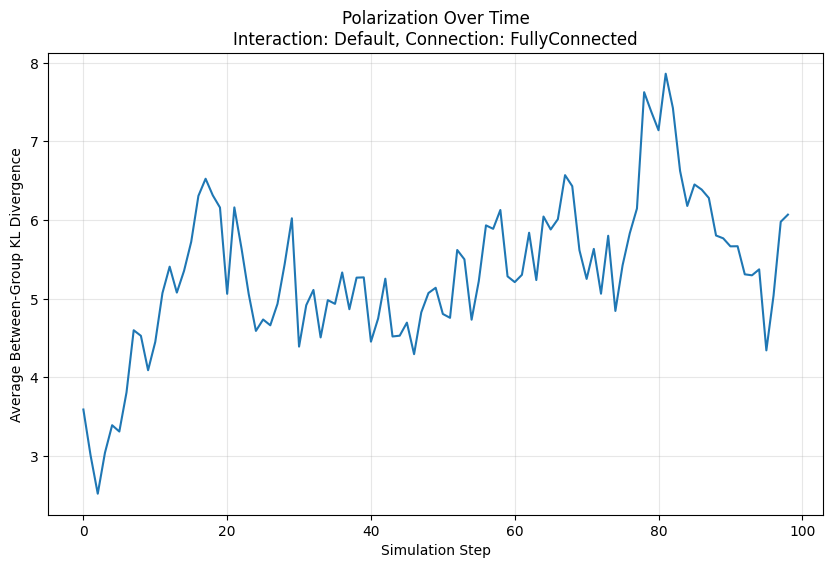

In [87]:
# Run the simulation with the strategies configured in the function
run_simulation()